[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!

Total sentiments in train set:
Sentiment
positive    560
negative     72
neutral      67
Name: count, dtype: int64

Total sentiments in test set:
Sentiment
positive    221
neutral      41
negative     38
Name: count, dtype: int64
Time to build vocab: 0.0 mins
Time to train the model: 0.13 mins
Epoch 1/10
----------
Epoch 1/10, Loss: 1.1046939221295444, Accuracy: 0.28612303290414876
Epoch 2/10
----------
Epoch 2/10, Loss: 1.0925037427382036, Accuracy: 0.36909871244635195
Epoch 3/10
----------
Epoch 3/10, Loss: 1.0806558240543713, Accuracy: 0.463519313304721
Epoch 4/10
----------
Epoch 4/10, Loss: 1.0689751343293623, Accuracy: 0.5565092989985694
Epoch 5/10
----------
Epoch 5/10, Loss: 1.0574327490546487, Accuracy: 0.6266094420600858
Epoch 6/10
----------
Epoch 6/10, Loss: 1.04600389437242, Accuracy: 0.6824034334763949
Epoch 7/10
----------
Epoch 7/10, Loss: 1.0346647175875

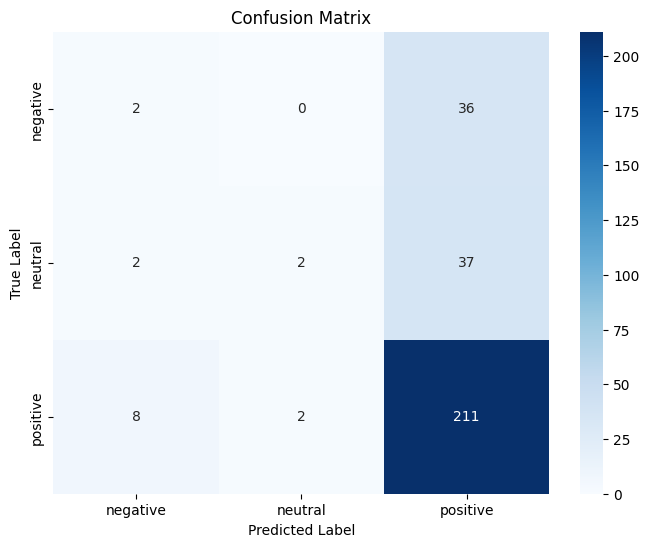

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
from time import time

# Load dataset
data_path = '/kaggle/input/tripadvisor-1000-dataset-examples/trip-advisor-copy.csv'
data = pd.read_csv(data_path)

# Preprocessing: Text Cleaning, Tokenization, and Normalization
nltk.download('punkt')

def clean_text(text):
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I | re.A)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

data['Cleaned_Review'] = data['Review'].apply(clean_text)

# Adjust labels for sentiment analysis
data['Sentiment'] = pd.cut(data['Rating'], bins=[-np.inf, 2, 3, np.inf], labels=['negative', 'neutral', 'positive'], right=False)

# Split data into train and test sets (70% train, 30% test)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['Cleaned_Review'], data['Sentiment'], test_size=0.3, random_state=42)

# Print total sentiment in train and test set
print("\nTotal sentiments in train set:")
print(train_labels.value_counts())

print("\nTotal sentiments in test set:")
print(test_labels.value_counts())

# Convert text data to TaggedDocuments for Doc2Vec
documents = [TaggedDocument(nltk.word_tokenize(text.lower()), [i]) for i, text in enumerate(data['Cleaned_Review'])]

# Train Doc2Vec model
cores = multiprocessing.cpu_count()
d2v_model = Doc2Vec(vector_size=300,
                    window=2,
                    min_count=2,
                    workers=cores-1,
                    epochs=40)

t = time()
d2v_model.build_vocab(documents)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

t = time()
d2v_model.train(documents, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

# Convert text data to Doc2Vec vectors
def text_to_vector(text):
    return d2v_model.infer_vector(nltk.word_tokenize(text.lower()), alpha=0.1, min_alpha=0.0001)

train_vectors = np.array([text_to_vector(text) for text in train_texts])
test_vectors = np.array([text_to_vector(text) for text in test_texts])

class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BiLSTMModel, self).__init__()
        self.bilstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # hidden_dim * 2 for bidirectional

    def forward(self, x):
        h_bilstm, _ = self.bilstm(x)
        out = self.fc(h_bilstm[:, -1, :])  # Get the output of the last time step
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiLSTMModel(input_dim=300, hidden_dim=128, output_dim=len(data['Sentiment'].unique()))
model = model.to(device)

class ReviewDataset(Dataset):
    def __init__(self, reviews, vectors, ratings):
        self.reviews = reviews
        self.vectors = vectors
        self.ratings = ratings

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        vector = self.vectors[idx]
        rating = self.ratings.iloc[idx]
        return {
            'vector': torch.tensor(vector, dtype=torch.float),
            'labels': torch.tensor(0 if rating == 'negative' else 1 if rating == 'neutral' else 2, dtype=torch.long)  # Adjusted labels
        }

def create_data_loader(reviews, vectors, ratings, batch_size):
    ds = ReviewDataset(reviews, vectors, ratings)
    return DataLoader(ds, batch_size=batch_size, num_workers=2)

BATCH_SIZE = 64  # Change batch size to 64
train_data_loader = create_data_loader(train_texts, train_vectors, train_labels, BATCH_SIZE)
test_data_loader = create_data_loader(test_texts, test_vectors, test_labels, BATCH_SIZE)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss().to(device)

# Training loop
EPOCHS = 10  # Set the number of epochs to 10

def train_epoch(model, data_loader, loss_fn, optimizer, device, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        vectors = d["vector"].unsqueeze(1).to(device)
        labels = d["labels"].to(device)

        outputs = model(vectors)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

# Main training loop with epoch print statements
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        len(train_texts)
    )

    print(f'Epoch {epoch + 1}/{EPOCHS}, Loss: {train_loss}, Accuracy: {train_acc}')

def get_predictions(model, data_loader):
    model = model.eval()
    predictions = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            vectors = d["vector"].unsqueeze(1).to(device)
            labels = d["labels"].to(device)

            outputs = model(vectors)
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds)
            real_values.extend(labels)

    return torch.stack(predictions).cpu(), torch.stack(real_values).cpu()

y_pred, y_true = get_predictions(model, test_data_loader)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
class_report = classification_report(y_true, y_pred, target_names=['negative', 'neutral', 'positive'])

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

# Confusion Matrix Visualization
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(conf_matrix, ['negative', 'neutral', 'positive'])
